# Classification Models

## Logistic Regression

Logistic regression estimates probabilities by using a logistic function. This has been the standard classification model for most sciences.

### Model Characterisitcs

- Runtime efficiency: Can use n_jobs if not using 'liblinear' solver.

- Preprocess data: If solver is set to 'sag' or 'saga', standardize so that convergence
works. Can handle sparse input.

- Prevent overfitting: The C parameter controls regularization. (Lower C is more
regularization, higher means less.) Can specify penalty to 'l1' or
'l2' (the default).

- Interpret results: The .coef_ attribute of the fitted model shows the decision function
coefficients. A change in x one unit changes the log odds ratio by the
coefficient. The .intercept_ attribute is the inverse log odds of the
baseline condition.

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import (impute, 
                     preprocessing)
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import (LogisticRegression)
from yellowbrick.model_selection.importances import FeatureImportances
import matplotlib.pyplot as plt 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import rfpimp
import xgboost as xgb
import lightgbm as lgb

In [3]:
# URL to the dataset
url = r"data/titanic.csv"

# Read the dataset
titanic_df = pd.read_csv(url)


orig_df = titanic_df

In [4]:
def clean_titanic(titanic_df: pd.DataFrame):
    """
        Perform cleaning on the Titanic dataset
    """    
    # Create a new copy of the Dataset without altering the orginal df 
    df = titanic_df.copy(deep=True)    
    # Drop irrelevant columns
    df = (
            df.drop(
                    columns=['body',
                             'cabin',
                             'boat',
                             'home.dest',
                             'name',
                             'ticket']  
                    )
             )
    
    # Convert the embarked column to categorical data
    df['embarked'] = (
                      df['embarked']
                      # Convert to categorical type
                      .astype('category')
                     )
    # Convert the sex column to categorical data
    df['sex'] = (
                df['sex']
                # Set as category
                .astype('category')
                )
    # Now lets create dummy columns for the categorical data and avoid Perfoect Colinearity
    df = pd.get_dummies(df, columns=['embarked', 'sex'], drop_first=True) 
    
    return df

In [5]:
def get_train_test_X_y(clean_titanic_df: pd.DataFrame, y_col: str, size: float = 0.3):
    # Get a copy of the original df
    df = clean_titanic_df.copy(deep=True)
    # Get the target
    y = df[y_col]
    # Get the features
    X = df.drop(columns=y_col)
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    # Get all feature cols
    feature_cols = X.columns
    # Get all Numeric columns
    num_cols = [
            'pclass',
            'age',
            'sibsp',
            'parch',
            'fare'
        ]

    cat_cols = [
                'embarked_Q',
                'embarked_S',
                'sex_male'
                ]

    # Impute the missing values based on characteristics of the numeric columns
    imputer = impute.IterativeImputer()

    X_train.loc[:, feature_cols] = imputer.fit_transform(X_train[feature_cols])

    X_test.loc[:, feature_cols] = imputer.transform(X_test[feature_cols])
    
    # Standardising the numeric columns
    scaler = preprocessing.StandardScaler()

    # Standardize the Numeric Features leaving out the Categorical features
    X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])


    # Standardising the test data
    X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])
    
    return X_train, X_test, y_train, y_test

In [6]:

#Cleaning Data
clean_df = clean_titanic(titanic_df=orig_df)


# Get the testing and training set
X_train, X_test, y_train, y_test = get_train_test_X_y(clean_titanic_df=clean_df, y_col='survived')


# Concatenate all the data
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)


In [7]:
# Logistic Regression

# Initialize the model
lr = LogisticRegression(random_state=42)

# Fit the model to the training set
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [8]:
lr.score(X_test, y_test)

0.8015267175572519

In [9]:
# Predict the class of the first row
lr.predict(X.iloc[[0]])

array([0], dtype=int64)

In [10]:
# Predict Probability
lr.predict_proba(X.iloc[[0]])

array([[0.89820343, 0.10179657]])

In [11]:
# Predict the log Probability
lr.predict_log_proba(X.iloc[[0]])

array([[-0.1073587, -2.2847789]])

In [12]:
lr.decision_function(X.iloc[[0]])

array([-2.1774202])

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


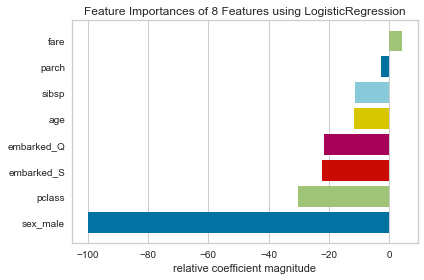

<AxesSubplot:title={'center':'Feature Importances of 8 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [26]:
# Showing the feature importances of the lr model

fig, ax = plt.subplots(figsize=(6,4))

fi_viz = FeatureImportances(lr)

fi_viz.fit(X,y)

# Beautify the visualization
fi_viz.poof()

## Naive Bayes

Naive Bayes is a probabilistic classifier that assumes independence between the features of the data. It is popular for text classification applications, such as catching spam. One advantage of this model is that because it assumes feature independence, it can train a model with a small number of samples. A downside is that it can’t capture the interactions between features.

> This simple model can also work with data that has many features. As such, it serves as a good baseline model.

This model has the following properties:
- Runtime efficiency: 
Training O(Nd), where N is the number of training examples and d is dimensionality. Testing O(cd), where c is the number of classes.
There are three classes in sklearn: `GaussianNB`, `MultinomialNB`, and `BernoulliNB`. The first assumes a Gaussian distribution (continuous features with a normal distribution), the second is for discrete occurrence counts, and the third is for discrete Boolean features.


- Preprocess data:
Assumes that data is independent. Should perform better after removing colinear columns. For continuous numerical data, might be good to bin data. Gaussian assumes normal distribution, and you might need to transform data to convert to normal distribution.

- Prevent overfitting:
Exhibits high bias and low variance (ensembles won’t reduce variance).

- Interpret results:
Percentage is the likelihood that a sample belongs to a class based on priors.

In [29]:
# Initialize the Gaussian NB Classifier Model
nb = GaussianNB()

# Fit the Gaussian NB Classifier Model to the training data
nb.fit(X_train, y_train)

# Get the score on the test set
nb.score(X_test, y_test)

0.7557251908396947

In [30]:
# Predict the records in the firs row
nb.predict(X.iloc[[0]])

array([0], dtype=int64)

In [31]:
# Now predict the probability
nb.predict_proba(X.iloc[[0]])

array([[0.95949468, 0.04050532]])

In [32]:
# Now predict the log probability
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04134851, -3.20632193]])

## Support Vector Machine

A Support Vector Machine (SVM) is an algorithm that tries to fit a line (or plane or hyperplane) between the different classes that maximizes the distance from the line to the points of the classes. In this way it tries to find a robust separation between the classes. The support vectors are the points of the edge of the dividing hyperplane.

SVMs have the following properties:

- Runtime efficiency: 
The scikit-learn implementation is O(n⁴), so it can be hard to scale to
large sizes. Using a linear kernel or the LinearSVC model can improve
the runtime performance at perhaps the cost of accuracy. Upping the
cache_size parameter can bring that down to O(n³).

- Preprocess data:
The algorithm is not scale invariant. Standardizing the data is highly
recommended.

- Prevent overfitting:
The C (penalty parameter) controls regularization. A smaller value
allows for a smaller margin in the hyperplane. A higher value for gamma
will tend to overfit the training data. The LinearSVC model supports a
loss and penalty parameter to support regularization.

- Interpret results:
Inspect .support_vectors_, though these are hard to explain. With
linear kernels, you can inspect .coef_.

In [34]:
# Initialize the SVC
svc_model = SVC(random_state=42, probability=True)

# Fit the SVC model to the Training Data
svc_model.fit(X_train, y_train)

# Get the SVC score
svc_model.score(X_test, y_test)

0.806615776081425

In [35]:
# Predict the first row
svc_model.predict(X.iloc[[0]])

array([0], dtype=int64)

In [36]:
# Predict the Probability
svc_model.predict_proba(X.iloc[[0]])

array([[0.84643281, 0.15356719]])

In [37]:
# Predict the log Probability
svc_model.predict_log_proba(X.iloc[[0]])

array([[-0.16672446, -1.87361708]])

## K-Nearest Neighbor

The K-Nearest Neighbor (KNN) algorithm classifies based on distance to
some number (k) of training samples. The algorithm family is called
instance-based learning as there are no parameters to learn. This model
assumes that distance is sufficient for inference; otherwise it makes no
assumptions about the underlying data or its distributions.


Nearest neighbor models have the following properties:

- Runtime efficiency:
Training O(1), but need to store data. Testing O(Nd) where N is the
number of training examples and d is dimensionality.

- Preprocess data:
Yes, distance-based calculations perform better when standardized.

- Prevent overfitting:
Raise n_neighbors. Change p for L1 or L2 metric.

- Interpret results:
Interpret the k-nearest neighbors to the sample (using the .kneighbors
method). Those neighbors (if you can explain them) explain your result.

In [45]:
# Instantiate the classifier model
knn_model = KNeighborsClassifier()

# Fit the training data
knn_model.fit(X_train, y_train)

# Get the score
knn_model.score(X_test, y_test)

0.7709923664122137

In [40]:
# Predicting a single record
knn_model.predict(X.iloc[[0]])

array([0], dtype=int64)

In [41]:
# Predicting Probabilities
knn_model.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

#### Key Parameters for KNN
- `n_neighbors=5`:
Number of neighbors.

- `p=2`:
Minkowski power parameter: 1 = manhattan (L1). 2 = Euclidean (L2).

- `weights='uniform'`:
Can be 'distance', in which case, closer points have more influence.
Distance metrics include: 'euclidean', 'manhattan', 'chebyshev',
'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis',

## Decision Tree

A decision tree is like going to a doctor who asks a series of questions to determine the cause of your symptoms. We can use a process to create a decision tree and have a series of questions to predict a target class. The advantages of this model include support for nonnumeric data (in some
implementations), little data preparation (no need for scaling), support for dealing with nonlinear relationships, feature importances are revealed, and it is easy to explain.

> The default algorithm used for creation is called the classification and
regression tree (CART). It uses the Gini impurity or index measure to
construct decisions. This is done by looping over the features and finding
the value that gives the lowest probability of misclassifying.


Decision trees have the following properties:
- `Runtime efficiency`:
For creation, loop over each of the m features, and sort all n samples,
O(mn log n). For predicting, you walk the tree, O( height).

- `Preprocess data`: 
Scaling is not necessary. Need to get rid of missing values and convert
to numeric.

- `Prevent overfitting`:
Set max_depth to a lower number, raise min_impurity_decrease.

- `Interpret results`:
Can step through the tree of choices. Because there are steps, a tree is
bad at dealing with linear relationships (a small change in a number can
go down a different path). The tree is also highly dependent on the
training data. A small change can change the whole tree.

In [47]:
# Instantiate the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Get the score on the test data
dt_model.score(X_test, y_test)

0.7608142493638677

In [48]:
# Predict a single record
dt_model.predict(X.iloc[[0]])

array([0], dtype=int64)

In [49]:
# Predict Probability
dt_model.predict_proba(X.iloc[[0]])

array([[0.88607595, 0.11392405]])

In [50]:
# Predict Log Probability
dt_model.predict_log_proba(X.iloc[[0]])

array([[-0.12095261, -2.17222328]])

Attributes after fitting:
- `classes_`:
Class labels

- `feature_importances_`:
Array of Gini importance

- `n_classes_`:
Number of classes

- `n_features_`:
Number of features

- `tree_`:
Underlying tree object

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


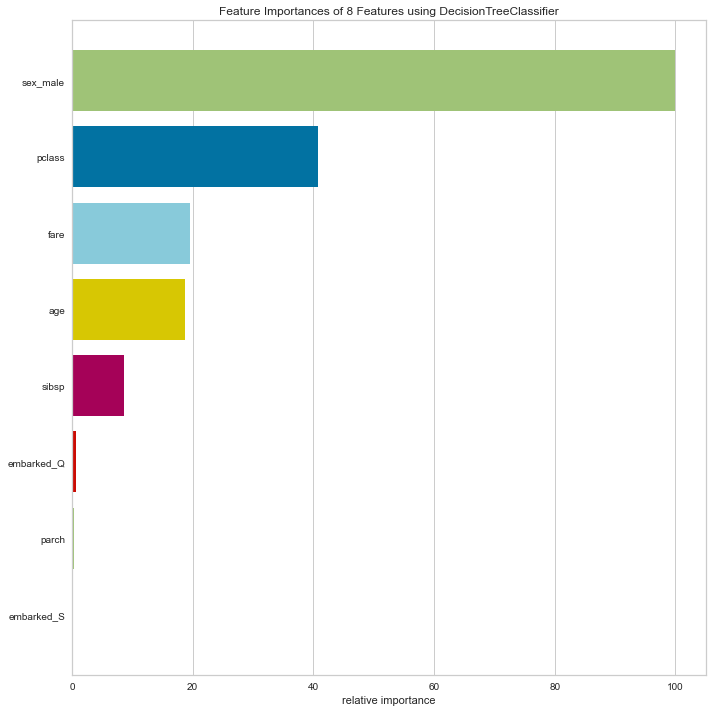

<AxesSubplot:title={'center':'Feature Importances of 8 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [53]:
# Visualize feature importance with Yellowbrick

fig, ax = plt.subplots(figsize=(10,10))

fi_viz = FeatureImportances(dt_model)

fi_viz.fit(X, y)

fi_viz.poof()

## Random Forest

A random forest is an ensemble of decision trees. It uses bagging to correct
the tendency of decision trees to overfit. By creating many trees trained on
random subsamples of the samples and random features of the data, the
variance is lowered.

The idea with random forests is to create a “forest” of decision trees trained
on different columns of the training data. If each tree has a better than 50%
chance of correct classification, you should incorporate its prediction. The
random forest has been an excellent tool for both classification and
regression, though it has recently fallen out of favor for gradient-boosted
trees.

- `Preprocess data`:
Not necessary.

- `Prevent overfitting`:
Add more trees (n_estimators). Use lower max_depth.

- `Interpret results`:
Supports feature importance, but we don’t have a single decision tree
that we can walk through. Can inspect single trees from the ensemble.

In [55]:
# Instantiate the model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Use the trained model for predicting and get the accuracy score
rf_model.score(X_test, y_test)

0.8015267175572519

In [57]:
# Instantiate the random forest model
rf_model_2 = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model_2.fit(X_train, y_train)

# Get the feature importance
rfpimp.importances(rf_model_2, X_test, y_test).Importance

Feature
sex_male      0.180662
pclass        0.055980
age           0.048346
parch         0.017812
sibsp         0.010178
embarked_Q    0.010178
fare          0.007634
embarked_S    0.002545
Name: Importance, dtype: float64

## XGBoost

XGBoost is a popular library outside of scikit-learn. It creates a weak tree and then “boosts” the subsequent trees to reduce the residual errors. It tries to capture and address any patterns in the errors until they appear to be random.

XGBoost has the following properties:

- `Runtime efficiency`:
XGBoost is parallelizeable. Use the n_jobs option to indicate the number of CPUs. Use GPU for even better performance.

- `Preprocess data`:
No scaling necessary with tree models. Need to encode categorical data.

- `Prevent overfitting`:
The early_stopping_rounds=N parameter can be set to stop training if there is no improvement after N rounds. L1 and L2 regularization are controlled by reg_alpha and reg_lambda, respectively. Higher
numbers are more conservative.

- `Interpret results`:
Has feature importance.

In [60]:
# Instantiate the xgboost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

# Get the score
xgb_model.score(X_test, y_test)

[0]	validation_0-logloss:0.57936
[1]	validation_0-logloss:0.52183
[2]	validation_0-logloss:0.49387
[3]	validation_0-logloss:0.47555
[4]	validation_0-logloss:0.47134
[5]	validation_0-logloss:0.46024
[6]	validation_0-logloss:0.45697
[7]	validation_0-logloss:0.45371
[8]	validation_0-logloss:0.45796
[9]	validation_0-logloss:0.45714
[10]	validation_0-logloss:0.45183
[11]	validation_0-logloss:0.45715
[12]	validation_0-logloss:0.45523
[13]	validation_0-logloss:0.45086
[14]	validation_0-logloss:0.45079
[15]	validation_0-logloss:0.45225
[16]	validation_0-logloss:0.45042
[17]	validation_0-logloss:0.45166
[18]	validation_0-logloss:0.45175
[19]	validation_0-logloss:0.45032
[20]	validation_0-logloss:0.45453
[21]	validation_0-logloss:0.45329
[22]	validation_0-logloss:0.45469
[23]	validation_0-logloss:0.45649
[24]	validation_0-logloss:0.45814
[25]	validation_0-logloss:0.45846
[26]	validation_0-logloss:0.45802
[27]	validation_0-logloss:0.46184
[28]	validation_0-logloss:0.46237
[29]	validation_0-loglos

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.7989821882951654

In [61]:
# Predict 1 record
xgb_model.predict(X.iloc[[0]])

array([0])

In [62]:
# Predict Probabilities 1 record
xgb_model.predict_proba(X.iloc[[0]])

array([[0.9273083 , 0.07269169]], dtype=float32)

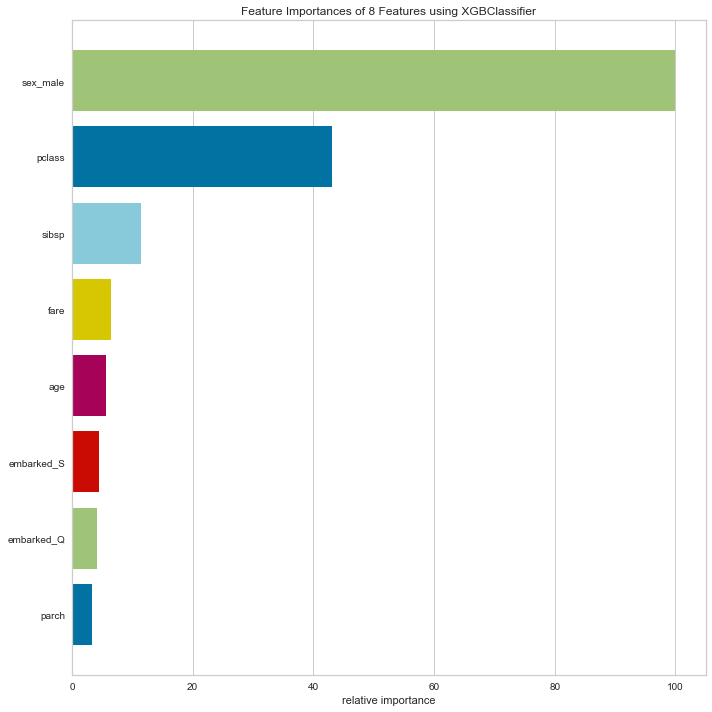

<AxesSubplot:title={'center':'Feature Importances of 8 Features using XGBClassifier'}, xlabel='relative importance'>

In [64]:
fig, ax = plt.subplots(figsize=(10,10))

fi_viz = FeatureImportances(xgb_model)

fi_viz.fit(X, y)

fi_viz.poof()

## Gradient Boosted with LightGBM

> LightGBM is an implementation by Microsoft. LightGBM uses a sampling mechanism to deal with continuous values. This allows quicker creation of trees (than say XGBoost), and reduces memory usage.

It has the following properties:

- `Runtime efficiency`:
Can take advantage of multiple CPUs. By using binning, can be 15 times faster than XGBoost.

- `Preprocess data`:
Has some support for encoding categorical columns as integers (or pandas Categorical type), but AUC appears to suffer compared to one-hot encoding.

- `Prevent overfitting`:
Lower num_leaves. Increase min_data_in_leaf. Use min_gain_to_split with lambda_l1 or lambda_l2.

- `Interpret results`:
Feature importance is available. Individual trees are weak and tend to be hard to interpret.

In [66]:
# Instantiate the lightgbm model
light_gbm_model = lgb.LGBMClassifier(random_state=42)

# Fit the classifier with the training data
light_gbm_model.fit(X_train, y_train)

# Get the Prediction score
light_gbm_model.score(X_test, y_test) 

0.8015267175572519

In [67]:
# Predict using LGBM Classifier
light_gbm_model.predict(X.iloc[[0]])

array([0], dtype=int64)

In [68]:
# Predict Probabilities using LGBM Classifier
light_gbm_model.predict_proba(X.iloc[[0]])

array([[0.96245378, 0.03754622]])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

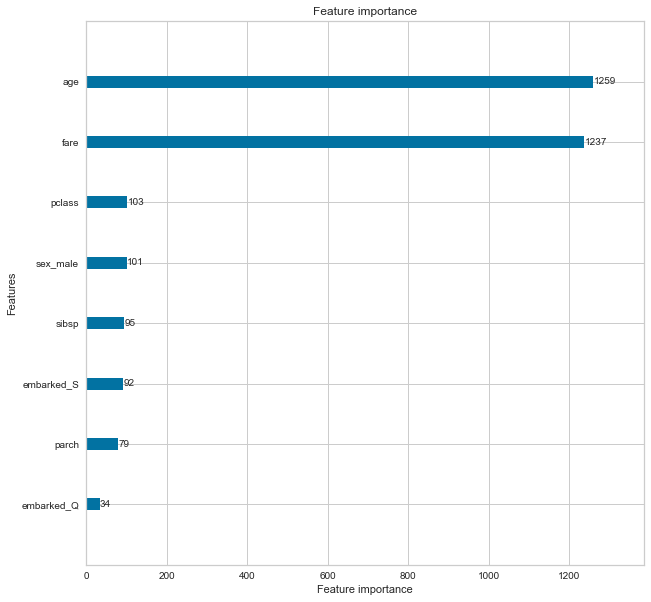

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

lgb.plot_importance(light_gbm_model, ax=ax)

# lgb.tight_layout()